In [1]:
import pandas as pd
import csv
import os,sys,json
from datetime import datetime, timedelta, date
import matplotlib
import matplotlib.pylab as plt
import re
from pylab import *
import tqdm
import numpy as np
%matplotlib inline
font = {'family' : 'Noto Sans CJK JP'}
matplotlib.rc('font', **font)

In [2]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [3]:
def display_full(df):
    max_rows = pd.get_option('display.max_rows')
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', max_rows)

In [4]:
!mkdir -p data/google/forecasts
!wget https://storage.googleapis.com/covid-external/forecast_STATE_28.csv -O data/google/forecasts/forecast_STATE_28-`date +%Y%m%d`.csv

--2021-04-21 16:33:11--  https://storage.googleapis.com/covid-external/forecast_STATE_28.csv
storage.googleapis.com (storage.googleapis.com) をDNSに問いあわせています... 2404:6800:4004:811::2010, 2404:6800:4004:821::2010, 2404:6800:4004:822::2010, ...
storage.googleapis.com (storage.googleapis.com)|2404:6800:4004:811::2010|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 561254 (548K) [application/octet-stream]
`data/google/forecasts/forecast_STATE_28-20210421.csv' に保存中

data/google/forecas 100%[===================>] 548.10K  --.-KB/s    in 0.06s   

2021-04-21 16:33:12 (8.46 MB/s) - `data/google/forecasts/forecast_STATE_28-20210421.csv' へ保存完了 [561254/561254]



In [5]:
target_date = datetime.datetime.now().strftime("%Y%m%d")
df = pd.read_csv("data/google/forecasts/forecast_STATE_28-%s.csv"%target_date)
df.set_index("target_prediction_date").sort_index()

,state_fips_code,state_name,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,...,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,intensive_care_patients_ground_truth,recovered_ground_truth,ventilator_patients_ground_truth,forecast_date,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth
target_prediction_date,,,,,,,,,,,,,,,,,,,,,
2021-03-22,25,MASSACHUSETTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16894.0,NaN,NaN,NaN,NaN,2021-04-18,NaN,NaN,NaN,NaN
2021-03-22,47,TENNESSEE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11713.0,NaN,NaN,NaN,NaN,2021-04-18,NaN,NaN,NaN,NaN
2021-03-22,40,OKLAHOMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4788.0,NaN,NaN,NaN,NaN,2021-04-18,NaN,NaN,NaN,NaN
2021-03-22,36,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49444.0,NaN,NaN,NaN,NaN,2021-04-18,NaN,NaN,NaN,NaN
2021-03-22,29,MISSOURI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8719.0,NaN,NaN,NaN,NaN,2021-04-18,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-16,19,IOWA,3.759266e+05,3.740603e+05,3.841213e+05,6127.705566,6093.256348,6260.877930,250.813110,243.623657,...,NaN,NaN,NaN,NaN,NaN,2021-04-18,7.061523,521.218750,NaN,NaN
2021-05-16,44,RHODE ISLAND,1.542200e+05,1.534527e+05,1.580385e+05,2744.387939,2728.958984,2804.027588,115.370224,112.082352,...,NaN,NaN,NaN,NaN,NaN,2021-04-18,2.621826,332.609375,NaN,NaN
2021-05-16,18,INDIANA,7.473826e+05,7.436658e+05,7.643112e+05,13713.290039,13636.199219,14010.777344,635.753967,617.437500,...,NaN,NaN,NaN,NaN,NaN,2021-04-18,14.604492,1181.312500,NaN,NaN


In [6]:
df.columns

Index(['state_fips_code', 'state_name', 'target_prediction_date',
       'cumulative_confirmed', 'cumulative_confirmed_q0025',
       'cumulative_confirmed_q0975', 'cumulative_deaths',
       'cumulative_deaths_q0025', 'cumulative_deaths_q0975',
       'hospitalized_patients', 'hospitalized_patients_q0025',
       'hospitalized_patients_q0975', 'intensive_care_patients',
       'intensive_care_patients_q0025', 'intensive_care_patients_q0975',
       'recovered', 'recovered_q0025', 'recovered_q0975',
       'ventilator_patients', 'ventilator_patients_q0025',
       'ventilator_patients_q0975', 'cumulative_confirmed_ground_truth',
       'cumulative_deaths_ground_truth', 'hospitalized_patients_ground_truth',
       'intensive_care_patients_ground_truth', 'recovered_ground_truth',
       'ventilator_patients_ground_truth', 'forecast_date', 'new_deaths',
       'new_confirmed', 'new_deaths_ground_truth',
       'new_confirmed_ground_truth'],
      dtype='object')

In [7]:
#total_df = df.loc[~df["new_confirmed"].isnull()].groupby("target_prediction_date").sum()
total_df = df.groupby("target_prediction_date").sum()
total_df

,state_fips_code,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,hospitalized_patients_q0975,...,cumulative_confirmed_ground_truth,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,intensive_care_patients_ground_truth,recovered_ground_truth,ventilator_patients_ground_truth,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth
target_prediction_date,,,,,,,,,,,,,,,,,,,,,
2021-03-22,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29757743.0,541121.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2021-03-23,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29811196.0,541979.0,0.0,0.0,0.0,0.0,0.000000,0.000000,858.0,53453.0
2021-03-24,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29897968.0,543457.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1478.0,86772.0
2021-03-25,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29965167.0,544984.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1527.0,67199.0
2021-03-26,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30042075.0,546122.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1138.0,76908.0
2021-03-27,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30104491.0,546899.0,0.0,0.0,0.0,0.0,0.000000,0.000000,777.0,62416.0
2021-03-28,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30146987.0,547413.0,0.0,0.0,0.0,0.0,0.000000,0.000000,514.0,42496.0
2021-03-29,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30215965.0,548120.0,0.0,0.0,0.0,0.0,0.000000,0.000000,707.0,68978.0
2021-03-30,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30277043.0,548995.0,0.0,0.0,0.0,0.0,0.000000,0.000000,875.0,61078.0


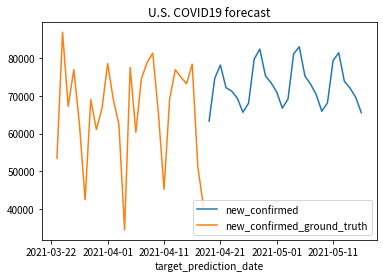

In [8]:
!mkdir -p google-covid19-forecast/us/
ax=total_df.replace(0, np.nan).plot(title="U.S. COVID19 forecast", y=["new_confirmed","new_confirmed_ground_truth"])
display(ax.figure)
plt.savefig("google-covid19-forecast/us/USA-total.png")
plt.close()

In [9]:
if False:
    for p, ddf in df.groupby("state_name"):
        ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p, y=["new_confirmed","new_confirmed_ground_truth"])
        display(ax.figure)
        plt.savefig("google-covid19-forecast/%s.png"%p)
        plt.close()

In [10]:
from functools import reduce

def read_one_week():
    today = datetime.datetime.now()
    stable_cols = ("target_prediction_date", "state_name", "new_confirmed_ground_truth")
    def data_for_date(target_date):
        filename = "data/google/forecasts/forecast_STATE_28-%s.csv"%target_date
        if not os.path.exists(filename):
            return None
        ddf = pd.read_csv(filename)
        result = ddf[[
            "target_prediction_date", "state_name", 
            "new_confirmed_ground_truth", "new_confirmed"]]
        result["target_prediction_date"] = pd.to_datetime(result["target_prediction_date"])
        columns={ 
            c: "%s_%s"%(c, target_date) if c not in stable_cols else c for c in result.columns 
        }
        result = result.rename(columns=columns)
        return result
    
    dates = [(today - datetime.timedelta(days=i)).strftime("%Y%m%d") for i in range(6, -1, -1)]
    data  = [data_for_date(d) for d in dates]
    truth = [d[1].set_index(['target_prediction_date', 'state_name'])["new_confirmed_ground_truth"].rename(d[0]) for d in zip(dates, data) if not d[1] is None]
    truth = reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'state_name'], how='outer'), truth)
    if len(truth.shape) > 1 and truth.shape[-1] > 1:
        truth = truth.max(axis=1)
    truth = truth.reset_index().set_index("target_prediction_date").sort_index()
    truth_avg = truth.groupby("state_name").rolling(7, center=True, min_periods=1).mean()
    truth_avg = truth_avg.reset_index().set_index(["target_prediction_date", "state_name"]).sort_index()
    truth = truth.reset_index().set_index(["target_prediction_date", "state_name"]).sort_index()
    truth = pd.concat([truth,truth_avg], axis=1, ignore_index=True)
    truth = truth.rename(columns={0: "new_confirmed", 1: "new_confirmed(avg)"})
    data = [d.drop(columns="new_confirmed_ground_truth") for d in data if not d is None]
    data = [truth] + data
    return reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'state_name'], how='outer'), data)
weekly_comparison = read_one_week()
display(weekly_comparison)

/home/seagetch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target_prediction_date,state_name,new_confirmed,new_confirmed(avg),new_confirmed_20210421
0,2021-03-22,ALABAMA,NaN,453.000000,NaN
1,2021-03-22,ALASKA,NaN,182.000000,NaN
2,2021-03-22,ARIZONA,NaN,416.666667,NaN
3,2021-03-22,ARKANSAS,NaN,268.000000,NaN
4,2021-03-22,CALIFORNIA,NaN,2621.666667,NaN
...,...,...,...,...,...
2851,2021-05-16,VIRGINIA,NaN,NaN,1378.375000
2852,2021-05-16,WASHINGTON,NaN,NaN,1292.156250
2853,2021-05-16,WEST VIRGINIA,NaN,NaN,304.859375
2854,2021-05-16,WISCONSIN,NaN,NaN,793.687500


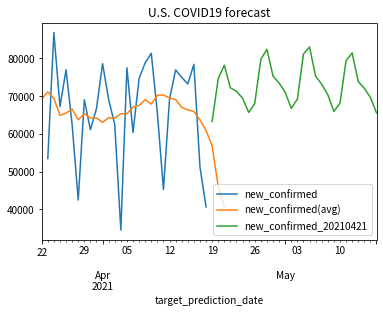

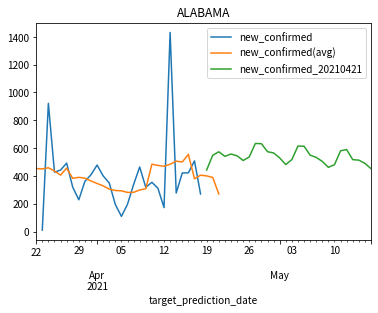

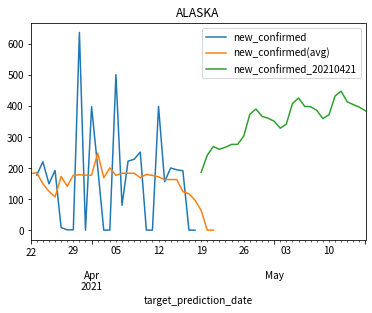

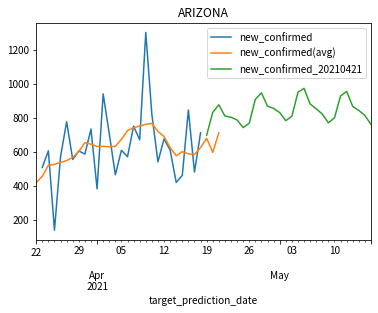

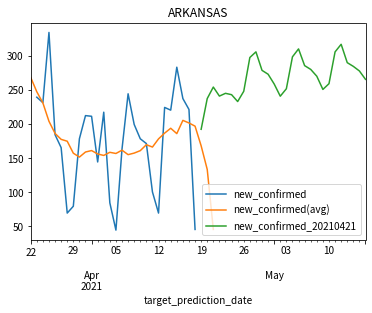

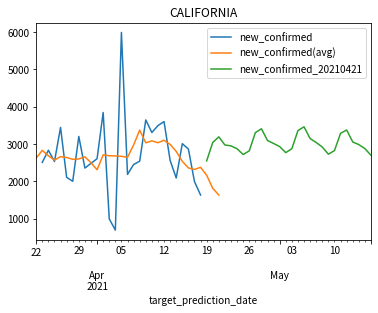

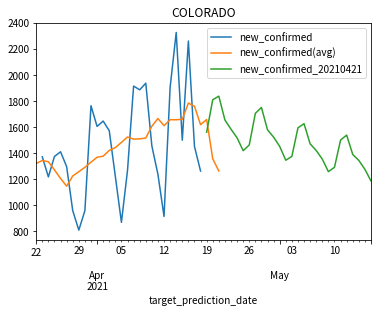

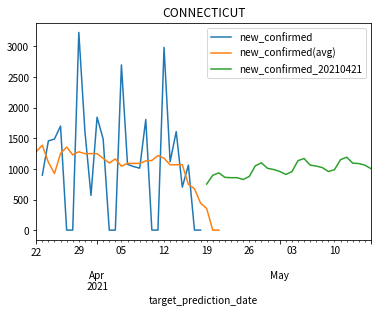

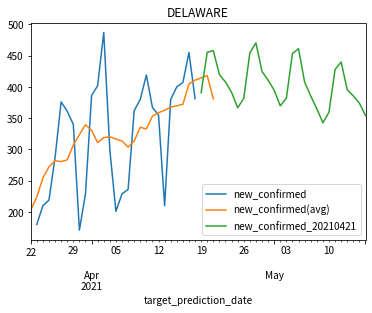

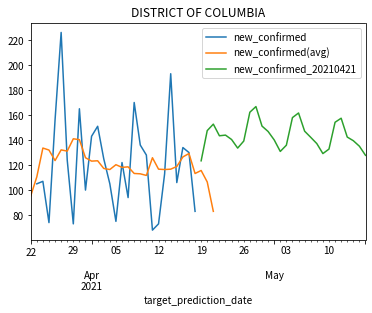

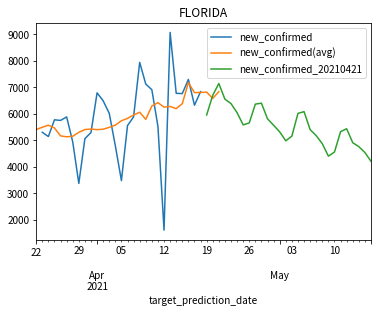

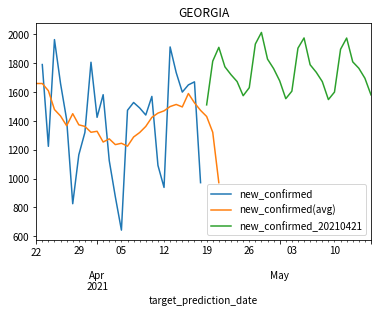

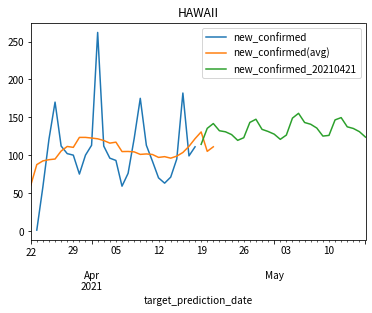

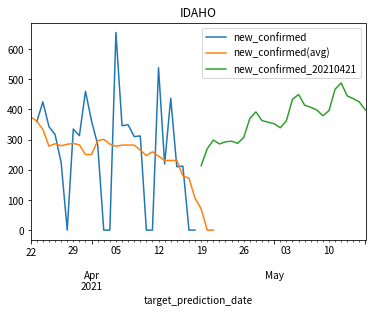

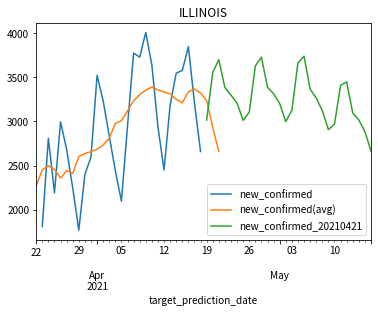

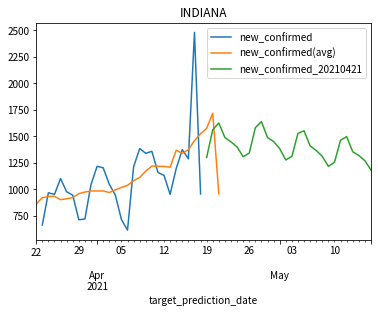

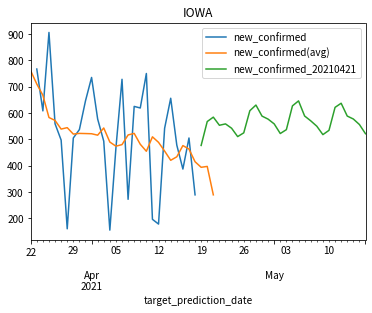

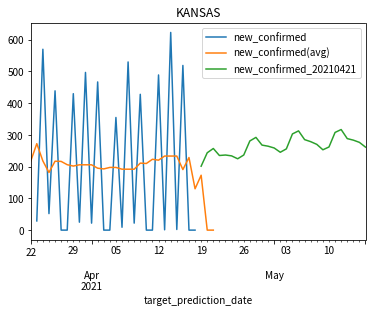

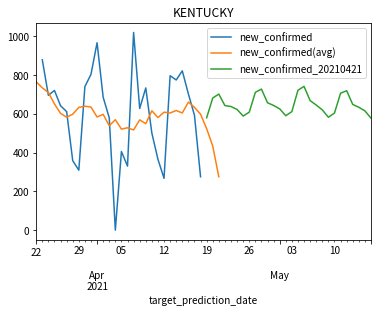

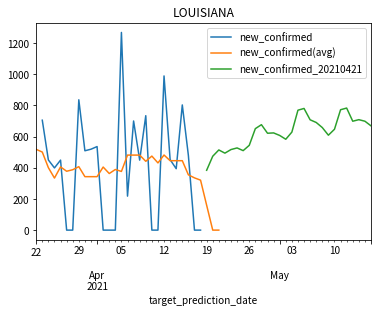

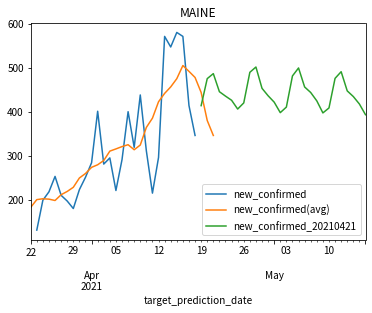

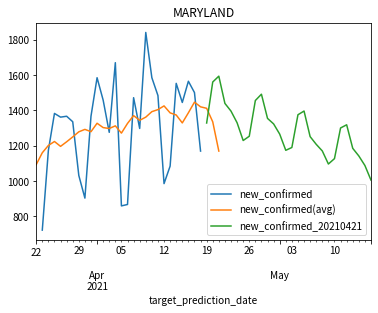

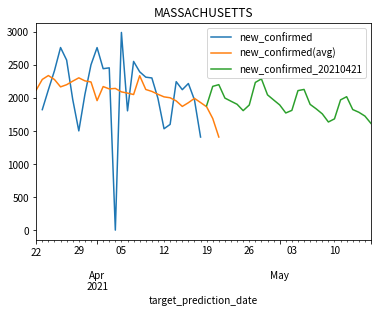

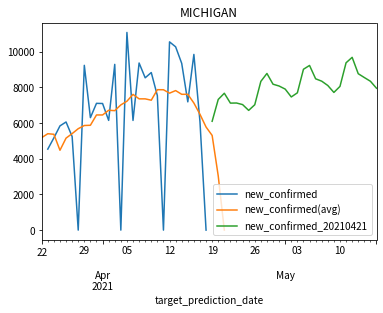

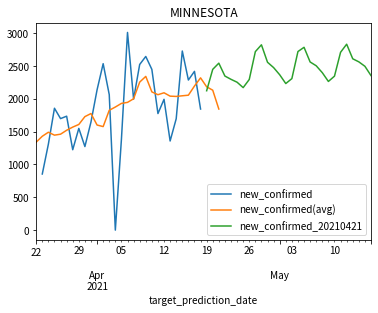

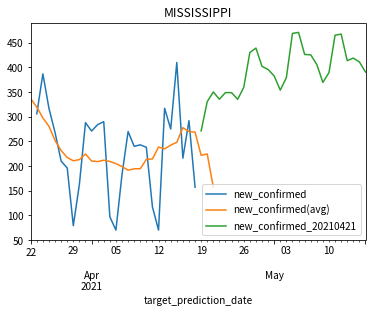

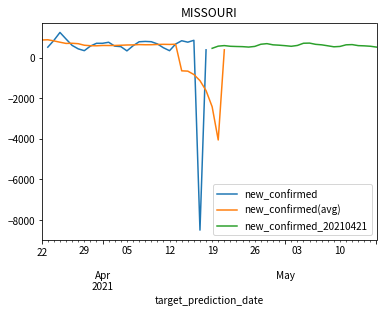

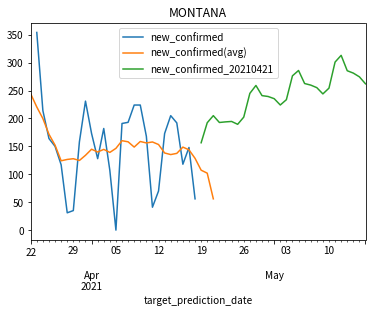

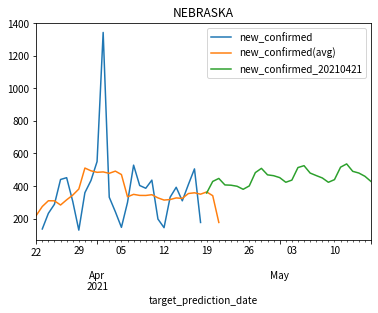

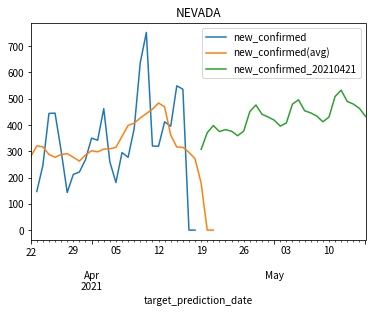

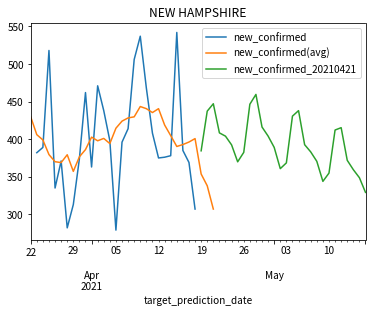

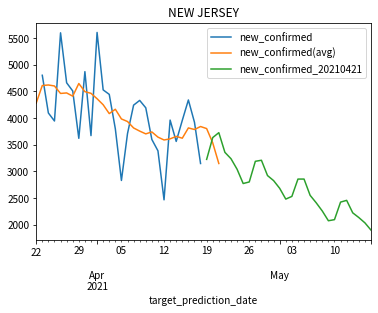

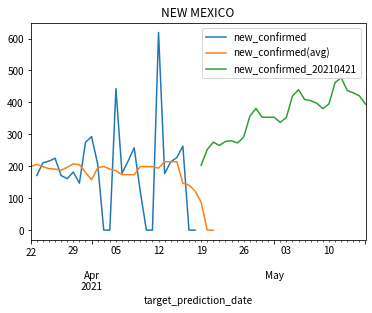

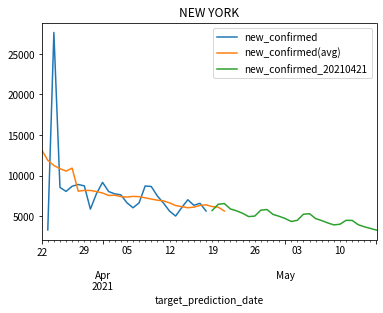

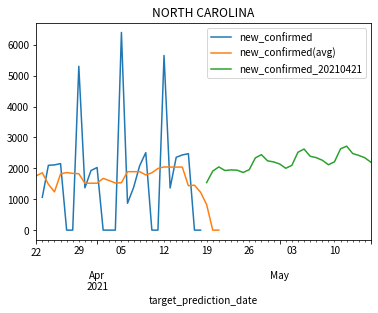

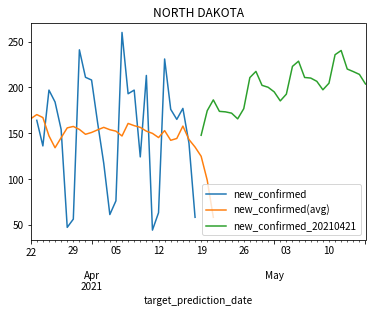

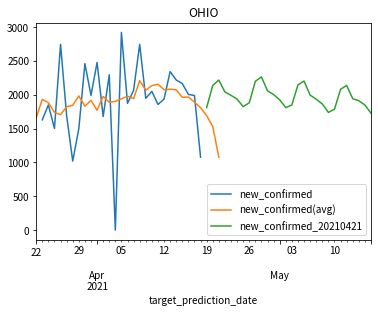

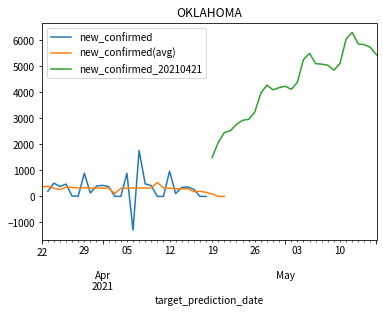

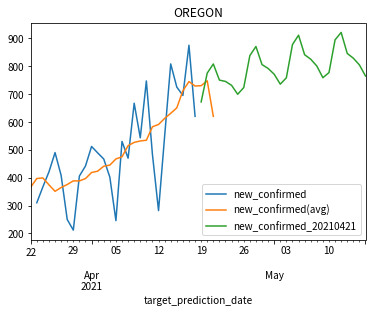

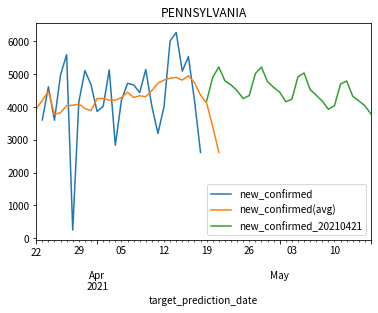

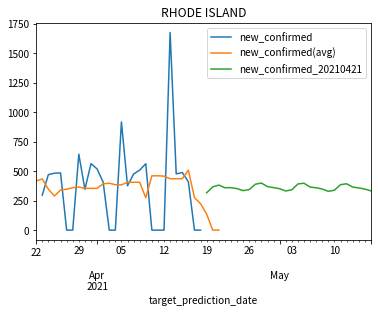

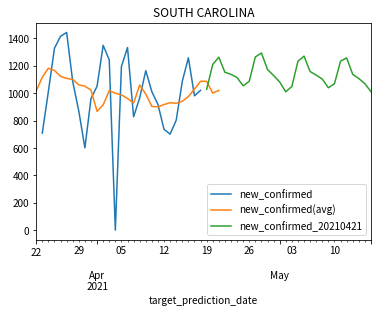

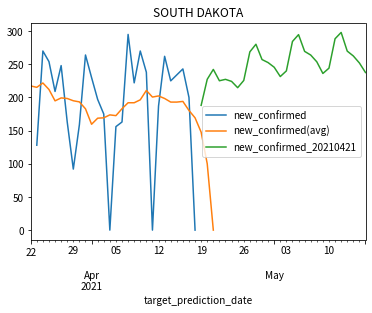

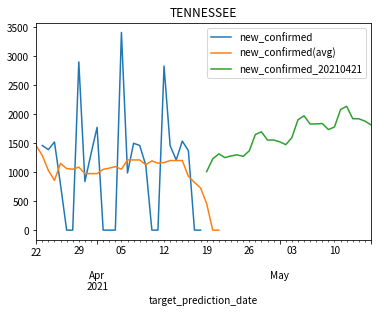

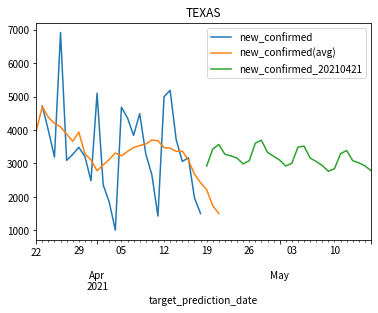

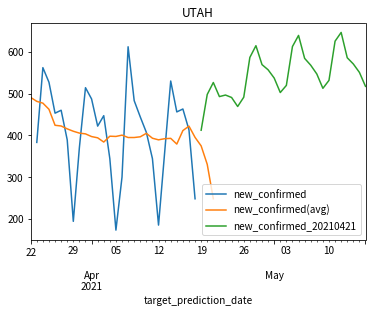

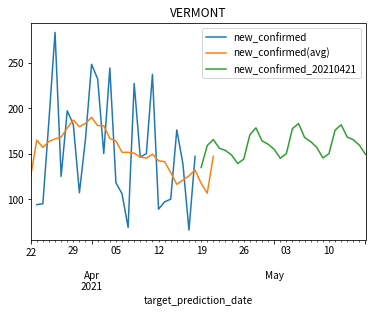

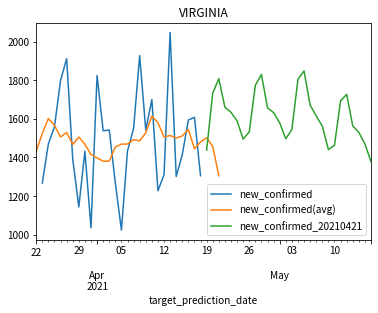

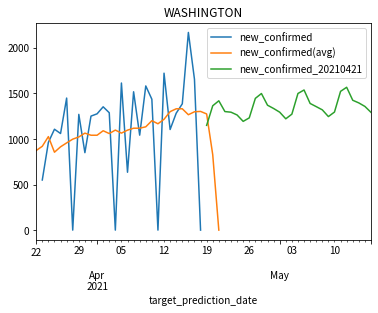

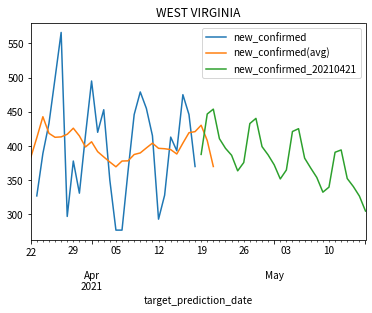

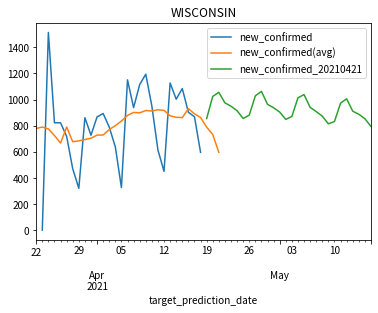

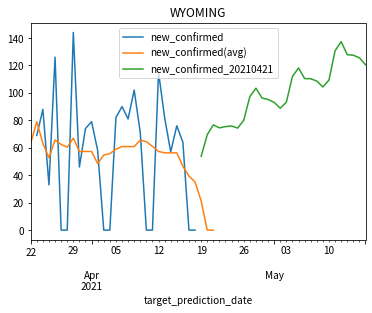

In [11]:
!mkdir -p google-covid19-forecast/us/

ax = weekly_comparison.groupby("target_prediction_date").sum().replace(0, np.nan).plot(title="U.S. COVID19 forecast")
display(ax.figure)
plt.savefig("google-covid19-forecast/us/USA-weekly.png")
plt.close()



for p, ddf in weekly_comparison.groupby("state_name"):
    ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p)
    display(ax.figure)
    plt.savefig("google-covid19-forecast/us/%s-weekly.png"%p)
    plt.close()

In [12]:
!zip google-covid19-forecast-us.zip google-covid19-forecast/us/*

updating: google-covid19-forecast/us/ALABAMA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ALASKA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ARIZONA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ARKANSAS-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/CALIFORNIA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/COLORADO-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/CONNECTICUT-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/DELAWARE-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/DISTRICT OF COLUMBIA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/FLORIDA-weekly.png (deflated 4%)
updating: google-covid19-forecast/us/GEORGIA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/HAWAII-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/IDAHO-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ILLINOIS-weekly.png (deflated 3%)
